<a href="https://colab.research.google.com/github/bilalProgTech/btech-nmims/blob/master/NN-DL/Lab-Work/20231015-Lab-9-BTech-NNDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip *.zip

# Variational Auto-Encoders (VAEs)

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
data = os.listdir('/content/img_align_celeba/img_align_celeba')
image_size = 64
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def parse_image(data):
    img = tf.io.read_file('/content/img_align_celeba/img_align_celeba/' + data)
    img = tf.image.decode_jpeg(img, channels=3)

    shapes = tf.shape(img)
    h, w = shapes[-3], shapes[-2]
    small = tf.minimum(h, w)

    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_crop_or_pad(img, small, small)
    img = tf.image.resize(img, [image_size, image_size], antialias=True)
    return img

In [ ]:
list_ds = tf.data.Dataset.from_tensor_slices(data[:5000])
images_ds = list_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
images_ds = images_ds.cache().shuffle(len(data)).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# retrieve a batch of images
image_batch = next(iter(images_ds))

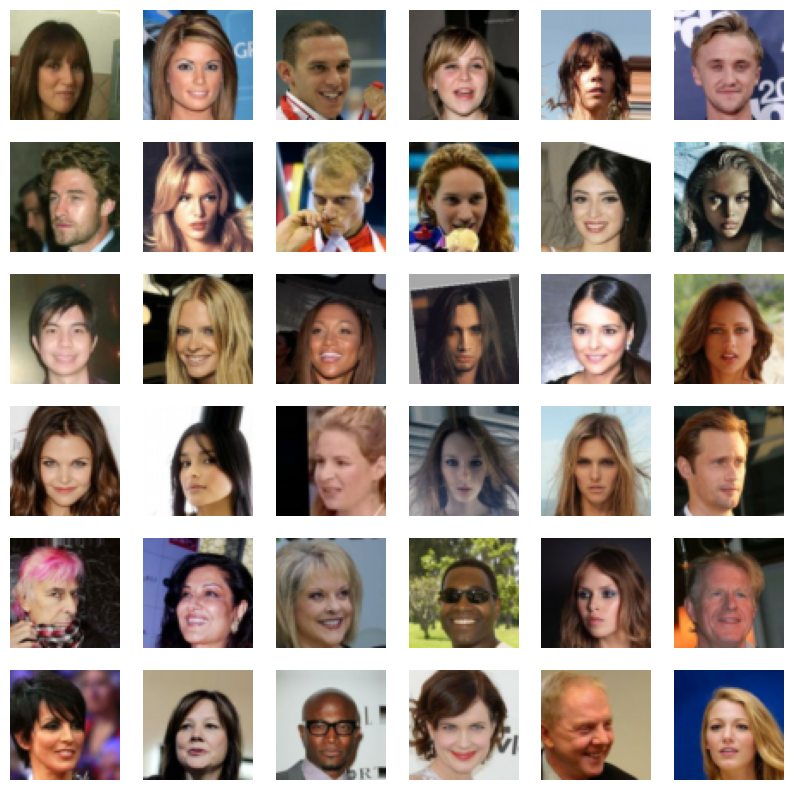

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(image_batch.numpy()[i])
    plt.axis("off")

In [ ]:
K = tf.keras.backend

In [ ]:
from keras.layers import Layer, InputLayer, Conv2D, BatchNormalization, Input
from keras.layers import LeakyReLU, Flatten, Dense, Conv2DTranspose, Reshape
from keras.models import Model

In [ ]:
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
latent_dim = 128

tf.keras.backend.clear_session()
encoder_inputs = Input((image_size, image_size, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(encoder_inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Flatten()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='Encoder')
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)           0         ['batch_normalization[0]

In [ ]:
decoder_inputs = Input((latent_dim, ))
x = Dense(128)(decoder_inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Dense(16384)(decoder_inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Reshape((8, 8, 256))(x)

x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

decoder_outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = Model(decoder_inputs, decoder_outputs, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_2 (Dense)             (None, 16384)             2113536   
                                                                 
 batch_normalization_5 (Bat  (None, 16384)             65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       295040    
 anspose)                                                  

In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
variational_ae = VAE(encoder, decoder)
variational_ae.compile(optimizer='adam')
variational_ae.fit(images_ds, epochs=500, batch_size=batch_size)

1/1 [==============================] - 0s 151ms/step


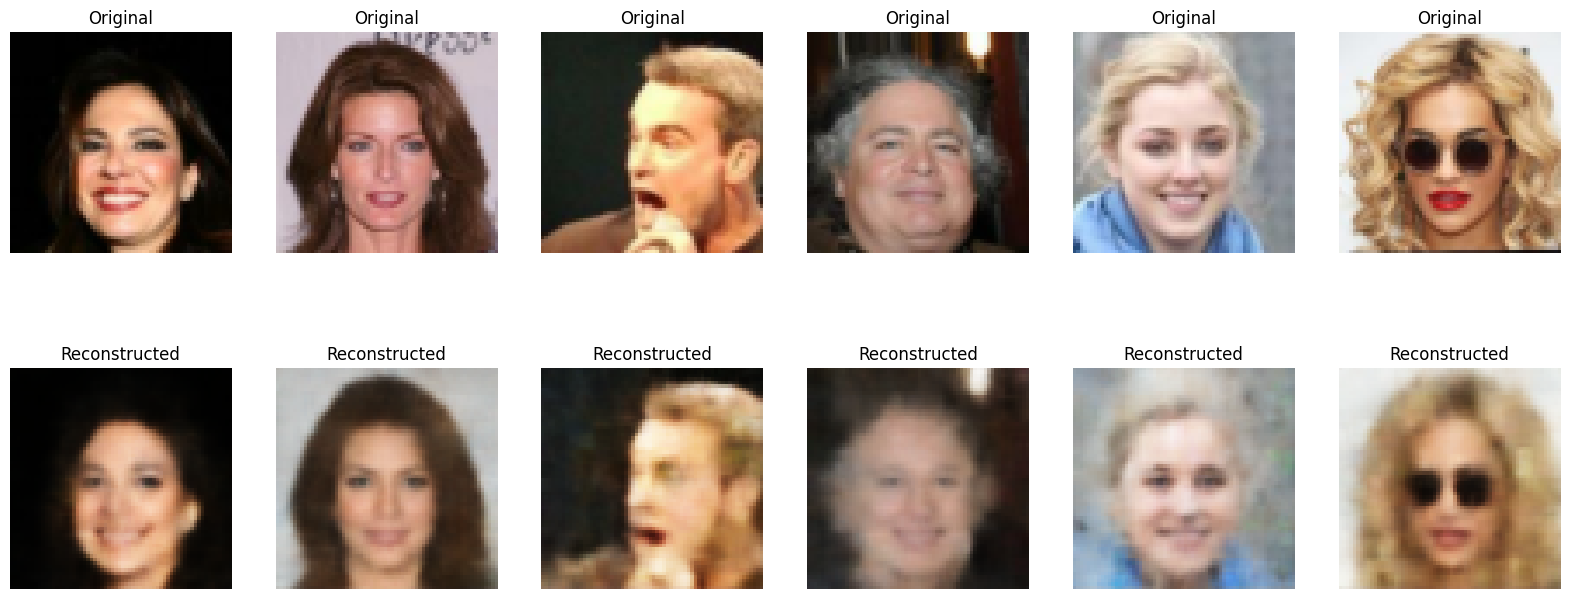

In [ ]:
# load test data
test_ds = tf.data.Dataset.from_tensor_slices(data[:6])
test_ds = test_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(6).prefetch(buffer_size=AUTOTUNE)
test_batch = next(iter(test_ds))

# Reconstructed images
encoded_data  = variational_ae.encoder.predict(test_ds)
decoded_data  = variational_ae.decoder.predict(encoded_data[0])

plt.figure(figsize=(20, 8))
for i in range(6):
    ax = plt.subplot(2, 6, i+1)
    plt.imshow(test_batch.numpy()[i])
    plt.title('Original')
    plt.gray()
    plt.axis("off")

    ax = plt.subplot(2, 6, i+1+6)
    plt.imshow(decoded_data[i])
    plt.title('Reconstructed')
    plt.gray()
    plt.axis("off")

plt.show()

In [ ]:
random_latent_vectors = tf.random.normal(shape=(36, latent_dim))
random_latent_vectors.shape

TensorShape([36, 128])

In [ ]:
random_generated = variational_ae.decoder.predict(random_latent_vectors)

2/2 [==============================] - 0s 6ms/step


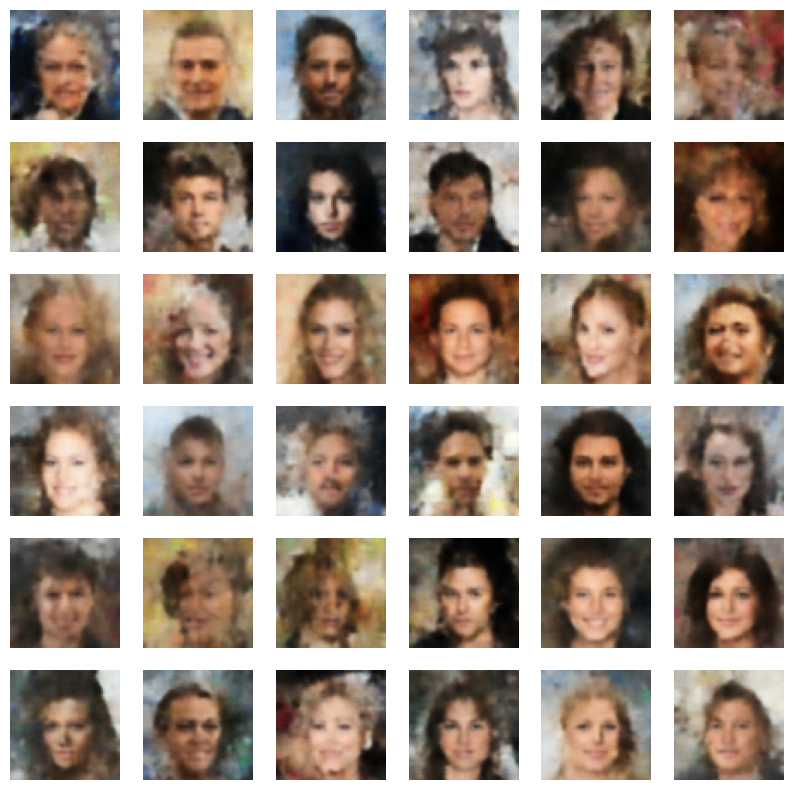

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(random_generated[i])
    plt.axis("off")

In [ ]:
image_list = []
n = 5
faces = 10
for i in range(n):
    z1 = tf.random.normal([1, latent_dim],0.0 ,1.0)
    z2 = tf.random.normal([1, latent_dim],0.0 ,1.0)
    for j in range(faces+1):
        z_in = (j/faces) * z1 + (1 - (j/faces)) * z2
        output = variational_ae.decoder.predict(z_in)
        image_list.append(output[0])

images = np.array(image_list)

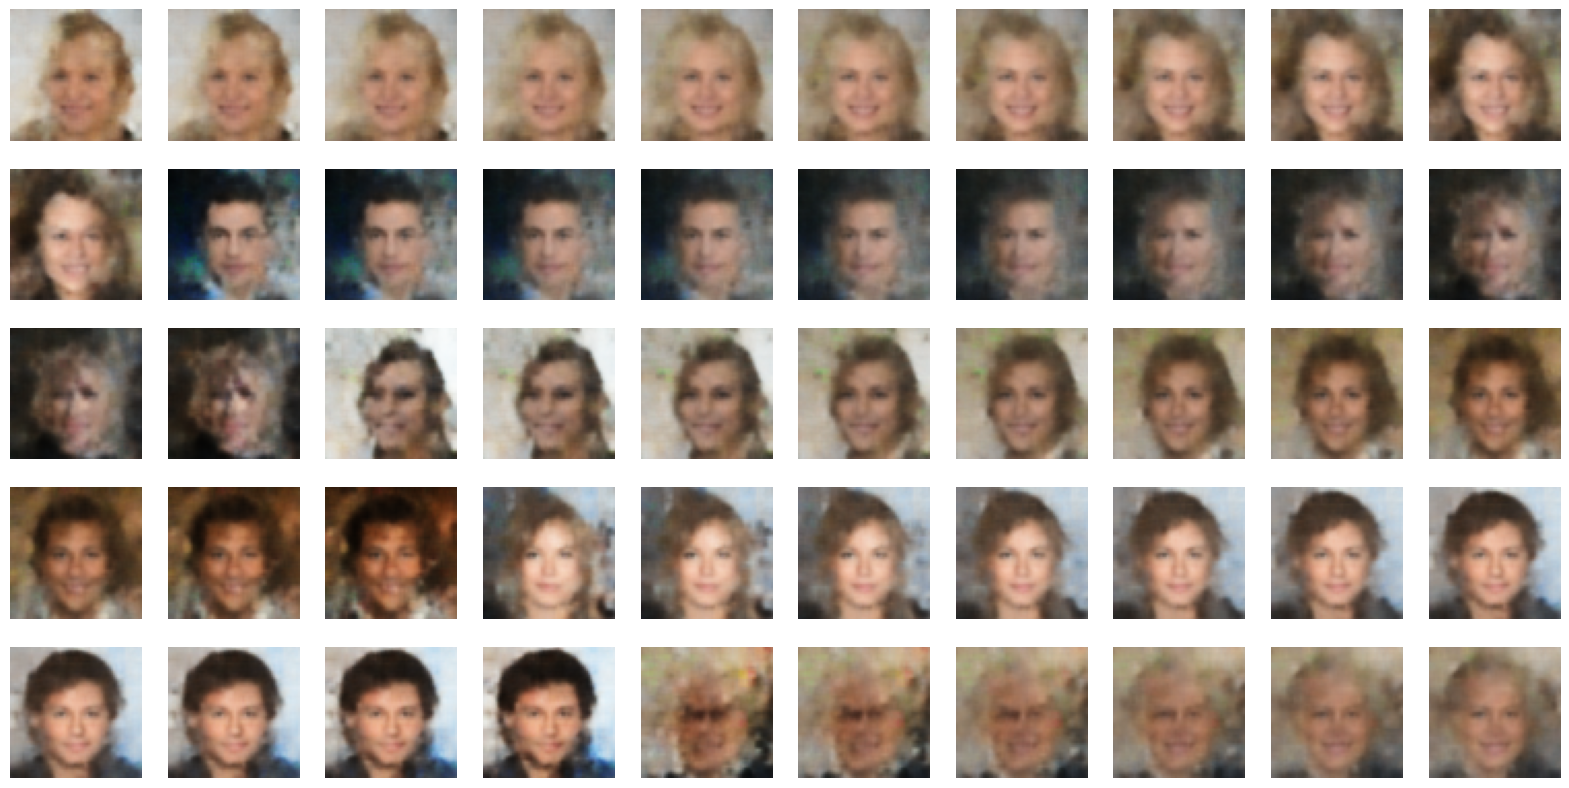

In [ ]:
plt.figure(figsize=(20, n*2))
for i in range(50):
    ax = plt.subplot(5, 10, i + 1)
    plt.imshow(images[i])
    plt.axis("off")